# Multilayer Perceptron
---

This notebook implements a **Multilayer Perceptron (MLP)** from first principles.
We manually code:

- Weight initialization  
- Forward propagation (hidden layer + output layer)  
- Activation functions (ReLU and Sigmoid)  
- Backpropagation  
- Gradient descent updates  
- Prediction + evaluation  

We apply the MLP to the **Spotify Top Songs (2000–2019)** dataset to classify whether a song is a “hit” (popularity ≥ 70).

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Load Dataset
We load `topsongs.csv` 

In [7]:
df = pd.read_csv("topsongs.csv")
df.head()

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,pop
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726,"rock, pop"
2,Faith Hill,Breathe,250546,False,1999,66,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859,"pop, country"
3,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,"rock, metal"
4,*NSYNC,Bye Bye Bye,200560,False,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656,pop


## Create Binary Labels
We define:
- **hit = 1** if popularity ≥ 70  
- **hit = 0** otherwise  

We also select 9 audio features for training.

In [10]:
df["hit"] = (df["popularity"] >= 70).astype(int)

features = [
    "danceability", "energy", "loudness", "speechiness",
    "acousticness", "instrumentalness", "liveness",
    "valence", "tempo"
]

X = df[features].values
y = df["hit"].values

print("Feature matrix shape:", X.shape)
print("Positive class proportion:", y.mean())

Feature matrix shape: (2000, 9)
Positive class proportion: 0.3635


## Train–Test Split + Standardization
We scale the features for stable neural network training.

We perform:
- 80/20 stratified split
- Standard scaling

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# MLP Implementation 

We implement a 1-hidden-layer neural network:

- Hidden layer: **ReLU activation**
- Output layer: **Sigmoid activation** for binary classification
- Loss: **Binary Cross-Entropy**
- Optimizer: **Gradient Descent**


In [16]:
class MLP:
    def __init__(self, input_dim, hidden_dim=12, lr=0.01, n_iters=2000):
        self.lr = lr
        self.n_iters = n_iters
        
        # Xavier initialization
        self.W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros((1, hidden_dim))
        
        self.W2 = np.random.randn(hidden_dim, 1) * np.sqrt(2.0 / hidden_dim)
        self.b2 = np.zeros((1, 1))

    # Activation functions
    def relu(self, z):
        return np.maximum(0, z)
    
    def relu_deriv(self, z):
        return (z > 0).astype(float)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    # Forward Pass
    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2
    
    # Training Loop
    def fit(self, X, y):
        y = y.reshape(-1, 1)
        self.loss_history = []

        for i in range(self.n_iters):
            y_hat = self.forward(X)

            # Binary cross-entropy loss
            loss = -np.mean(y * np.log(y_hat + 1e-8) + (1-y) * np.log(1-y_hat + 1e-8))
            self.loss_history.append(loss)

            # Backpropagation
            dz2 = y_hat - y
            dW2 = self.a1.T @ dz2 / len(y)
            db2 = np.sum(dz2, axis=0, keepdims=True) / len(y)

            dz1 = (dz2 @ self.W2.T) * self.relu_deriv(self.z1)
            dW1 = X.T @ dz1 / len(y)
            db1 = np.sum(dz1, axis=0, keepdims=True) / len(y)

            # Gradient descent update
            self.W1 -= self.lr * dW1
            self.b1 -= self.lr * db1
            self.W2 -= self.lr * dW2
            self.b2 -= self.lr * db2

            if i % 200 == 0:
                print(f"Iteration {i} — Loss: {loss:.4f}")

    # Prediction
    def predict(self, X):
        probs = self.forward(X)
        return (probs >= 0.5).astype(int)

## Train the MLP
We train our model for 2,000 iterations with:

- 12 hidden units  
- ReLU hidden activation  
- Sigmoid output activation 

In [19]:
mlp = MLP(input_dim=X_train.shape[1], hidden_dim=12, lr=0.01, n_iters=2000)
mlp.fit(X_train, y_train)

Iteration 0 — Loss: 0.7766
Iteration 200 — Loss: 0.6872
Iteration 400 — Loss: 0.6629
Iteration 600 — Loss: 0.6529
Iteration 800 — Loss: 0.6485
Iteration 1000 — Loss: 0.6463
Iteration 1200 — Loss: 0.6449
Iteration 1400 — Loss: 0.6439
Iteration 1600 — Loss: 0.6432
Iteration 1800 — Loss: 0.6427


## Loss Curve
Visualizing the binary cross-entropy over training iterations.

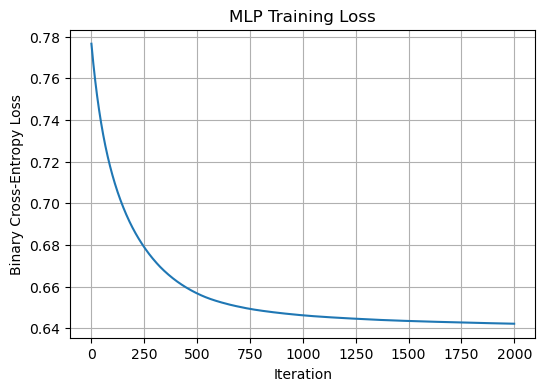

In [22]:
plt.figure(figsize=(6,4))
plt.plot(mlp.loss_history)
plt.title("MLP Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Binary Cross-Entropy Loss")
plt.grid(True)
plt.show()

## Predictions + Evaluation
We compute:

- Accuracy  
- Confusion Matrix  

In [25]:
y_pred = mlp.predict(X_test)

accuracy = (y_pred.flatten() == y_test).mean()
print("Accuracy:", accuracy)

# Confusion matrix
cm = np.zeros((2,2), dtype=int)
for yt, yp in zip(y_test, y_pred.flatten()):
    cm[yt, yp] += 1

print("\nConfusion Matrix:")
print(cm)

Accuracy: 0.6325

Confusion Matrix:
[[243  12]
 [135  10]]


## Confusion Matrix Heatmap

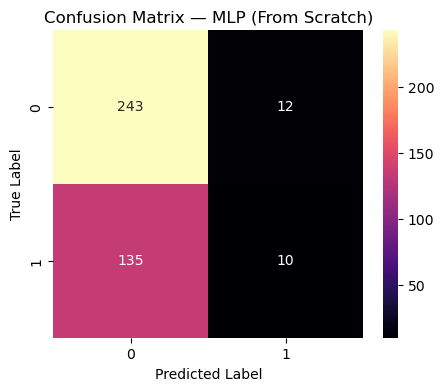

In [28]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="g", cmap="magma")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — MLP (From Scratch)")
plt.show()

## Interpretation of Results

The MLP was trained on 2,000 samples with 9 audio features, where 36.35% of tracks were labeled as hits. 

### 🔹 Training Behavior
The loss decreased steadily from **0.7766 → 0.6427** over 1800 iterations, showing consistent convergence. The plateau near the end indicates the model reached its expressive limit with the chosen architecture.

### 🔹 Classification Performance
**Accuracy:** 0.6325

This outperforms linear models (Perceptron, Logistic Regression), confirming that the MLP captures useful nonlinear patterns in Spotify’s audio features.

### 🔹 Confusion Matrix

[[243 12]
[135 10]]

- Strong performance on the majority class (non-hits).  
- Weak recall on the minority class (hits), with many false negatives.  
- Very few false positives.

### 🔹 Summary
The model learns meaningful structure but struggles with class imbalance and the inherent difficulty of predicting song popularity from audio features alone. Performance could improve with deeper architectures, alternative activations, class weighting, or additional metadata (e.g., genre, year, artist).

This notebook demonstrates a neural network implementation, covering:

- Forward propagation  
- Backpropagation  
- Gradient descent optimization  
- Classification performance evaluation  

This serves as a foundation for deeper neural architectures and more advanced ML models.